## Data Loading

In [364]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score


from utils import *
from models import *
from constants import *

def split_array_by_indices_and_sizes(array, df):
    subarrays = []
    for _, row in df.iterrows():
        start = row['index']
        size = row['size']
        subarrays.append(array[start:start + size])
    return subarrays


def cusum_test(normalized_residuals, target=0, k=0.5):
    S_pos = [0]
    S_neg = [0]

    # Two-sided CUSUM test
    for i in range(1, len(normalized_residuals)):
        S_pos.append(max(0, S_pos[i-1] + normalized_residuals[i] - target - k))
        S_neg.append(min(0, S_neg[i-1] + normalized_residuals[i] - target + k))

    S_pos = np.array(S_pos)
    S_neg = np.array(S_neg)

    return S_neg, S_pos

def get_cusum(df, model, df_for_scaling):
    X, y = df[FEATURES].to_numpy(), df[OUTPUT_FEATURE].to_numpy()
    X_for_scaling = df_for_scaling[FEATURES].to_numpy()

    scaler = StandardScaler()
    scaler.fit(X_for_scaling)
    X = scaler.transform(X)
    y_pred = np.array(model(X).mean()).ravel()
    y_stddevs = np.array(model(X).stddev()).ravel()
    normalized_residuals = (y - y_pred) / y_stddevs
    S_neg, S_pos = cusum_test(normalized_residuals)
    return S_neg, S_pos

def is_out_of_control(S_neg, S_pos, h):
    """
    Determines if the control chart is out of control and returns the index of the first value out of control.

    Parameters:
        S_neg (np.ndarray): Array representing the negative side of the control chart.
        S_pos (np.ndarray): Array representing the positive side of the control chart.
        h (float): Control limit threshold.

    Returns:
        tuple: (status, index)
            - status (int): 1 if out of control, 0 otherwise.
            - index (int or None): The index of the first value out of control, or None if in control.
    """
    # Check for the first value out of control in S_neg
    neg_out_of_control = np.where(S_neg < -h)[0]
    if len(neg_out_of_control) > 0:
        # print(len(S_neg), neg_out_of_control[0], 1)
        return 1, len(S_neg) - neg_out_of_control[0] + 1

    # Check for the first value out of control in S_pos
    pos_out_of_control = np.where(S_pos > h)[0]
    if len(pos_out_of_control) > 0:
        return 1, len(S_pos) - pos_out_of_control[0] + 1

    # If no values are out of control, return 0 and None
    return 0, None

In [365]:
df_all = pd.read_pickle(open(DATA_PATH + '/unfiltered/full.pkl','rb'))
df_scaling = pd.read_pickle(open(DATA_PATH + '/cleaned_temp/train.pkl','rb'))
# df_healthy = pd.read_pickle(open(DATA_PATH + '/cleaned/full.pkl','rb'))
df_healthy = pd.read_pickle(open(DATA_PATH + '/cleaned_temp/test.pkl','rb'))

In [366]:
df_scaling = df_scaling[df_scaling['turbine'] == TURBINE_ID]
df_scaling.set_index('Date.time', inplace=True)
df_scaling = df_scaling.dropna(subset=FEATURES + [OUTPUT_FEATURE])

In [367]:
df_all = df_all[df_all['turbine'] == TURBINE_ID]
df_all['Date.time'] = pd.to_datetime(df_all['Date.time'])
df_all.set_index('Date.time', inplace=True)
print(df_all.shape)
df_all = df_all.dropna(subset=FEATURES + [OUTPUT_FEATURE])
print(df_all.shape)
df_all.head(3)

(195137, 116)
(192892, 116)


,Wind.dir.std,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,...,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year,Wind.dir.sin.me,Wind.dir.cos.me,Wind.dir.sin.min,Wind.dir.cos.min,Wind.dir.sin.max,Wind.dir.cos.max
Date.time,,,,,,,,,,,,,,,,,,,,,
2017-09-25 00:00:00,4.975697,170.785782,18.711275,117.633080,201.376236,178.246281,4.758976,0.470051,3.839334,5.655419,...,34.605957,12.856477,5,2017,0.430621,-0.902533,0.595533,-0.803331,0.272135,-0.962259
2017-09-25 00:10:00,5.446428,196.361282,29.352943,132.657440,244.603409,214.993427,5.053728,0.455439,4.297034,5.879260,...,24.391794,12.387291,5,2017,0.487182,-0.873300,0.611509,-0.791238,0.301869,-0.953350
2017-09-25 00:20:00,6.676327,213.066101,18.548962,175.467987,244.880829,186.659122,4.834767,0.438846,3.727230,5.667759,...,19.414160,14.047290,5,2017,0.478421,-0.878131,0.610129,-0.792302,0.207282,-0.978281


In [368]:
df_healthy = df_healthy[df_healthy['turbine'] == TURBINE_ID]
df_healthy.set_index('Date.time', inplace=True)
print(df_healthy.shape)
df_healthy = df_healthy.dropna(subset=FEATURES + [OUTPUT_FEATURE])
print(df_healthy.shape)
df_healthy.head(3)

(32713, 117)
(32713, 117)


,index,Wind.dir.std,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,...,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year,Wind.dir.sin.me,Wind.dir.cos.me,Wind.dir.sin.min,Wind.dir.cos.min,Wind.dir.sin.max,Wind.dir.cos.max
Date.time,,,,,,,,,,,,,,,,,,,,,
2020-09-28 20:30:00,934504,5.585499,38.692450,11.581096,15.45063,66.552727,53.601896,3.45408,0.550072,2.471102,...,63.168377,25.480147,5,2020,-0.769083,-0.639149,-0.629349,-0.777123,-0.869565,-0.493819
2020-09-28 20:40:00,934505,6.667247,19.518286,8.171135,9.10151,35.959888,37.251639,3.23313,0.439212,2.389428,...,48.180819,18.454353,5,2020,-0.770149,-0.637864,-0.614857,-0.788639,-0.869908,-0.493214
2020-09-28 20:50:00,934506,5.583571,-3.239987,11.164587,-16.03763,19.505760,0.000000,2.55610,0.338663,2.150343,...,29.063781,16.004997,5,2020,-0.639338,-0.768926,-0.481064,-0.876685,-0.792577,-0.609772


In [370]:
checkpoint_path = 'saved_models_paper3/mlp_finetuned.keras'
mlp_large_finetuned = create_model_mlp_gaussian_joint(df_healthy[FEATURES].to_numpy(), MODELS_SEED)
mlp_large_finetuned.summary()
mlp_large_finetuned.load_weights(checkpoint_path)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 100)                  4100      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 80)                   8080      ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['dense_1[0][0]']             
                                                                                              

In [371]:
X, y = df_healthy[FEATURES].to_numpy(), df_healthy[OUTPUT_FEATURE].to_numpy()
X_for_scaling = df_scaling[FEATURES].to_numpy()

scaler = StandardScaler()
scaler.fit(X_for_scaling)
X = scaler.transform(X)
y_pred = np.array(mlp_large_finetuned(X).mean()).ravel()
y_stddevs = np.array(mlp_large_finetuned(X).stddev()).ravel()
normalized_residuals = (y - y_pred) / y_stddevs

In [372]:
a = normalized_residuals
a.mean()

0.027142866247841874

In [373]:
(y - y_pred).mean()

0.3317410440980332

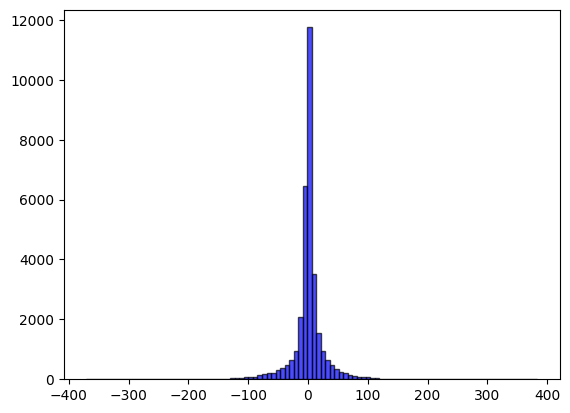

In [374]:
plt.hist((y - y_pred), bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.show()

In [375]:
y_stddevs

array([2.9945748, 3.398748 , 4.4702506, ..., 4.1391435, 4.5260057,
       3.8862662], dtype=float32)

In [376]:
# Find the subset where array2 is smaller than array1
subset1 = y[y_pred < y]
subset2 = y_pred[y_pred < y]
subset3 = y_pred[y_pred >= y]

print("Subset from array1:", subset1)
print("Subset from array2:", subset2)

Subset from array1: [19.51828599 28.02334707 40.56620359 ... 78.25198776 91.5367595
 59.05318481]
Subset from array2: [17.333961 27.425423 39.294254 ... 77.9823   86.938    58.360306]


In [377]:
len(subset3)

16020

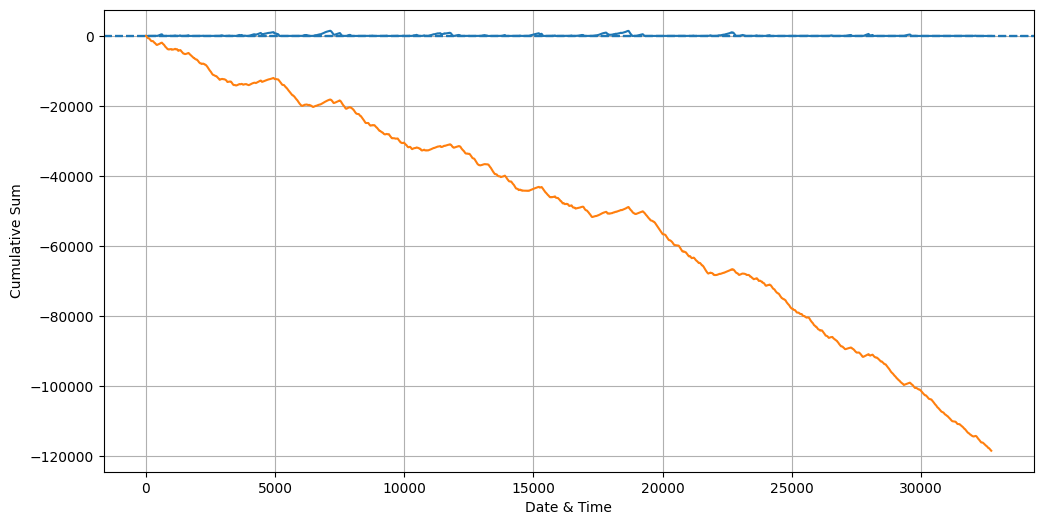

In [378]:
S_neg_healthy, S_pos_healthy = get_cusum(df_healthy, mlp_large_finetuned, df_healthy)
plt.figure(figsize=(12, 6))
plt.plot(S_pos_healthy, label='S' + '\u2095')
plt.plot(S_neg_healthy, label='S' + '\u2097')
plt.axhline(y=5, linestyle='--', label='-I')
plt.axhline(y=-5, linestyle='--', label='I')
plt.axhline(y=4.5, linestyle='--', label='-I2')
plt.axhline(y=-4.5, linestyle='--', label='I2')
plt.xlabel('Date & Time')
plt.ylabel('Cumulative Sum')
plt.grid(True)

In [379]:
TIMESTAMP_START_COL = 'Timestamp start'
TIMESTAMP_END_COL ='Timestamp end'

df_status = pd.read_excel(DATA_PATH + '/status_file/status.xlsx', sheet_name='Status file')

df_status = df_status[df_status['Wind Turbine'] == TURBINE_ID]
df_status[TIMESTAMP_START_COL] = pd.to_datetime(df_status[TIMESTAMP_START_COL])
df_status[TIMESTAMP_END_COL] = df_status[TIMESTAMP_END_COL].apply(
    lambda x: pd.to_datetime(x) if x!='-' else x
)
df_status = df_status[df_status[TIMESTAMP_END_COL] != '-'].reset_index(drop=True)

df_faults = df_status[(df_status['Status'] == 'Stop') & (df_status['IEC category'] == 'Forced outage')]
df_faults.reset_index(drop=True, inplace=True)
print(df_faults.shape)
df_faults.head(3)

(71, 10)


,Wind Turbine,Timestamp start,Timestamp end,Duration,Status,Code,Message,Comment,Service contract category,IEC category
0,5,2016-01-24 15:12:45,2016-01-24 18:25:59,03:13:14,Stop,110,Emergency stop top box,NaN,Emergency stop switch (Nacelle) (11),Forced outage
1,5,2016-01-26 16:54:08,2016-01-26 16:56:14,00:02:06,Stop,1510,Low gearbox oil pressure,NaN,Mechanical error (23),Forced outage
2,5,2016-01-27 09:11:04,2016-01-27 09:13:27,00:02:23,Stop,4510,Tower oscillation Y level 1,NaN,Safety stop of WEC (15),Forced outage


In [380]:
for t in df_faults[TIMESTAMP_START_COL]:
    print(t)

2016-01-24 15:12:45
2016-01-26 16:54:08
2016-01-27 09:11:04
2016-01-27 09:27:54
2016-01-27 09:34:42
2016-01-27 09:37:40
2016-01-27 09:48:00
2016-01-27 09:51:18
2016-01-28 16:01:18
2016-02-02 18:51:32
2016-02-04 20:03:42
2016-02-05 07:39:46
2016-02-05 16:30:08
2016-02-05 17:13:41
2016-02-22 11:27:33
2016-04-21 14:25:46
2016-10-12 12:16:31
2017-01-11 12:30:30
2017-02-23 09:14:45
2017-02-23 09:57:25
2017-02-23 10:46:15
2017-02-23 11:33:13
2017-02-23 11:57:55
2017-02-23 12:18:54
2017-02-23 12:58:18
2017-02-23 13:11:51
2017-02-23 14:38:52
2017-02-23 14:57:16
2017-02-23 15:45:05
2017-09-13 03:49:16
2017-10-23 14:31:19
2018-01-03 02:02:18
2018-01-18 03:12:48
2018-01-18 04:12:05
2018-01-24 09:49:07
2018-04-02 05:14:41
2018-04-11 08:11:40
2018-04-16 10:39:01
2018-06-15 08:53:15
2018-10-12 15:00:20
2018-11-29 11:23:58
2018-12-18 11:05:02
2019-03-03 20:11:14
2019-03-03 20:59:55
2019-03-03 21:42:24
2019-03-03 21:57:00
2019-03-16 10:55:19
2019-06-01 15:25:31
2019-11-04 11:20:34
2019-11-05 15:07:39


In [381]:
df_faults

,Wind Turbine,Timestamp start,Timestamp end,Duration,Status,Code,Message,Comment,Service contract category,IEC category
0,5,2016-01-24 15:12:45,2016-01-24 18:25:59,03:13:14,Stop,110,Emergency stop top box,NaN,Emergency stop switch (Nacelle) (11),Forced outage
1,5,2016-01-26 16:54:08,2016-01-26 16:56:14,00:02:06,Stop,1510,Low gearbox oil pressure,NaN,Mechanical error (23),Forced outage
2,5,2016-01-27 09:11:04,2016-01-27 09:13:27,00:02:23,Stop,4510,Tower oscillation Y level 1,NaN,Safety stop of WEC (15),Forced outage
3,5,2016-01-27 09:27:54,2016-01-27 09:29:01,00:01:07,Stop,100,Safety chain open,NaN,Safety chain (13),Forced outage
4,5,2016-01-27 09:34:42,2016-01-27 09:36:13,00:01:31,Stop,1510,Low gearbox oil pressure,NaN,Mechanical error (23),Forced outage
...,...,...,...,...,...,...,...,...,...,...
66,5,2021-02-02 16:04:11,2021-02-02 16:06:10,00:01:59,Stop,3000,Frequency converter not ready,NaN,Generator and Converter errors (20),Forced outage
67,5,2021-02-02 16:08:36,2021-02-02 16:10:36,00:02:00,Stop,3000,Frequency converter not ready,NaN,Generator and Converter errors (20),Forced outage
68,5,2021-02-02 16:12:40,2021-02-02 16:14:40,00:02:00,Stop,3000,Frequency converter not ready,NaN,Generator and Converter errors (20),Forced outage
69,5,2021-02-02 16:16:40,2021-02-02 16:29:28,00:12:48,Stop,3000,Frequency converter not ready,NaN,Generator and Converter errors (20),Forced outage


### Faulty

In [382]:
pre_faults = {}

# 48h before faults
for i, start_time in enumerate(df_faults[TIMESTAMP_START_COL]):
    mask_pre_fault = (df_all.index >= start_time - pd.Timedelta(hours=72)) & (df_all.index < start_time)

    if i > 0:
        mask_pre_fault = mask_pre_fault & (df_all.index > df_faults[TIMESTAMP_START_COL][i-1])
    if len(df_all[mask_pre_fault]) < 144: 
        continue
    pre_faults[start_time] = df_all[mask_pre_fault]

for fault_start_time, df_pre_fault in pre_faults.items():
    print(fault_start_time, len(df_pre_fault))

2017-10-23 14:31:19 432
2018-01-03 02:02:18 432
2018-01-18 03:12:48 432
2018-01-24 09:49:07 432
2018-04-02 05:14:41 432
2018-04-11 08:11:40 432
2018-04-16 10:39:01 432
2018-06-15 08:53:15 432
2018-10-12 15:00:20 402
2018-11-29 11:23:58 432
2018-12-18 11:05:02 432
2019-03-03 20:11:14 432
2019-03-16 10:55:19 432
2019-06-01 15:25:31 431
2019-11-04 11:20:34 432
2020-02-09 07:36:07 432
2020-02-15 17:52:19 432
2020-07-02 13:35:32 376
2020-08-25 15:01:12 390
2020-09-22 08:34:37 397
2021-02-02 16:04:11 392
2021-03-11 05:07:23 432


In [383]:
len(pre_faults)

22

In [430]:
def plot_cusum(S_pos, S_neg, h, datetime_values, save_path):
    colors = ['#445469', '#772E15']

    # Find the index of the first occurrence where the control limit is surpassed
    control_index_pos = next((i for i, value in enumerate(S_pos) if value > h), None)
    control_index_neg = next((i for i, value in enumerate(S_neg) if value < -h), None)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(datetime_values, S_pos, linestyle='--', label='S' + '\u2095', color=colors[0], linewidth=2.5)
    plt.plot(datetime_values, S_neg, linestyle='-.', label='S' + '\u2097', color=colors[1], linewidth=2.5)
    plt.axhline(y=h, color=colors[0], label='-I', linewidth=2.5)
    plt.axhline(y=-h, color=colors[1], label='I', linewidth=2.5)
    plt.text(datetime_values.iloc[-1], h + 0.3, f'I = {h}', 
             color=colors[0], ha='right', fontsize=14, va='bottom', weight='bold')
    plt.text(datetime_values.iloc[-1], -h - 0.3, f'-I = {-h}', 
             color=colors[1], ha='right', fontsize=14, va='top', weight='bold')
    plt.xlabel('Date & Time', fontsize=16)  # Increase font size of the x-axis label
    plt.ylabel('Cumulative Sum', fontsize=16)  # Increase font size of the y-axis label

    y_min = -30
    y_max = 30
    plt.ylim(-h * 1.5, h * 1.5)

    if min(S_neg) < y_min:
        plt.ylim(y_min * 1.1, y_max)
    if max(S_pos) > y_max:
        plt.ylim(y_min, y_max * 1.1)

    indices = np.linspace(0, len(datetime_values) - 1, 5, dtype=int)
    selected_dates = pd.to_datetime(datetime_values.iloc[indices])

    plt.xticks(selected_dates, [date.strftime('%Y-%m-%d\n%H:%M') for date in selected_dates], rotation=45, ha='right')

    # Make font size of tick labels larger
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)

    if control_index_pos is not None:
        plt.scatter(datetime_values.iloc[control_index_pos], S_pos[control_index_pos], color='none', edgecolor='red', linewidths=2, s=200, zorder=5)
        plt.text(datetime_values.iloc[control_index_pos], S_pos[control_index_pos] + 0.75, 
                 datetime_values.iloc[control_index_pos].strftime('%Y-%m-%d\n%H:%M'), 
                 ha='right', fontsize=16, color='black', va='top', zorder=6,
                 bbox=dict(boxstyle="round", ec='black', fc='white', alpha=0.5))
    # if control_index_neg is not None:
    #     plt.scatter(datetime_values.iloc[control_index_neg], S_neg[control_index_neg], color='none', edgecolor='red', linewidths=2, s=200, zorder=5)
    #     plt.text(datetime_values.iloc[control_index_neg], S_neg[control_index_neg] - 0.75, 
    #              datetime_values.iloc[control_index_neg].strftime('%Y-%m-%d\n%H:%M'), 
    #              ha='right', fontsize=14, color='black', va='top', zorder=6,
    #              bbox=dict(boxstyle="round", ec='black', fc='white', alpha=0.5))
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()


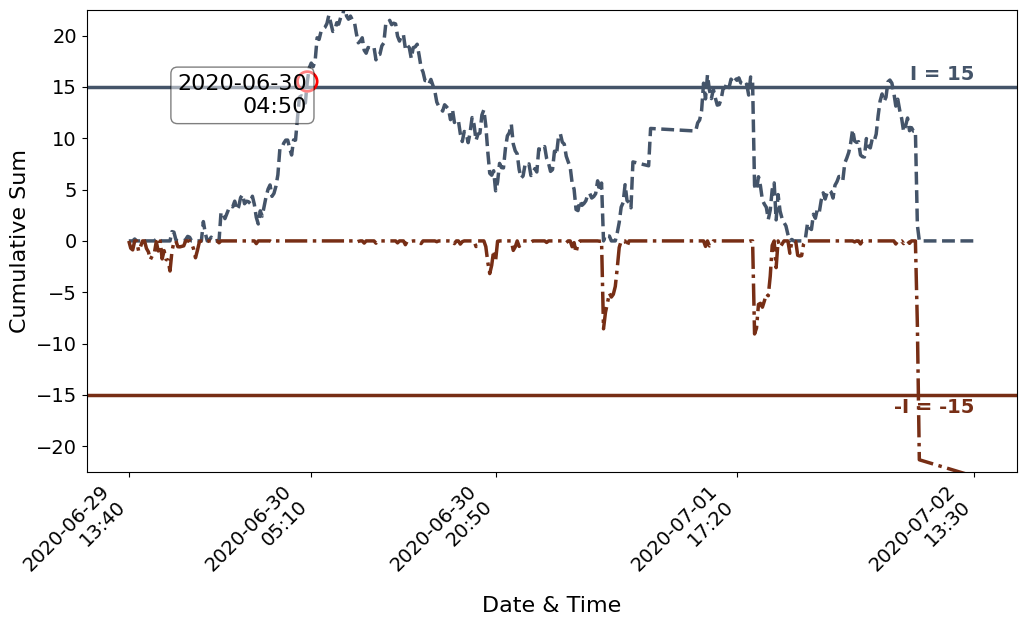

In [431]:
S_neg_faulty_charts = []
S_pos_faulty_charts = []

for i, (st, df) in enumerate(pre_faults.items()):
    S_neg, S_pos = get_cusum(df, mlp_large_finetuned, df_scaling)
    S_neg_faulty_charts.append(S_neg)
    S_pos_faulty_charts.append(S_pos)
    
    if i == 17: plot_cusum(S_pos, S_neg, 15, pd.Series(df.index), save_path='plots_final/A1/cusum_faulty.pdf')

### Healthy

In [386]:
k = 14  # Days away

# Define exclusion periods
exclusion_periods = [(t - pd.Timedelta(days=k), t + pd.Timedelta(days=k)) for t in df_faults[TIMESTAMP_START_COL]]

# Merge overlapping exclusion periods
merged_periods = []
for start, end in sorted(exclusion_periods):
    if not merged_periods or merged_periods[-1][1] < start:
        merged_periods.append((start, end))
    else:
        merged_periods[-1] = (merged_periods[-1][0], max(merged_periods[-1][1], end))

# Create dictionary of valid periods
result = {}
last_end = df_healthy.index.min()

for start, end in merged_periods:
    if last_end < start:
        valid_period = df_healthy[(df_healthy.index >= last_end) & (df_healthy.index < start)]
        if not valid_period.empty:
            result[valid_period.index.min()] = valid_period
    last_end = max(last_end, end)

# Add final period if it exists
if last_end < df_healthy.index.max():
    valid_period = df_healthy[df_healthy.index >= last_end]
    if not valid_period.empty:
        result[valid_period.index.min()] = valid_period

# Output result
for key, value in result.items():
    print(f"Period starting {key}:\n{value}\n")


Period starting 2020-10-06 14:40:00:
                      index  Wind.dir.std     Power.me    Power.sd  \
Date.time                                                            
2020-10-06 14:40:00  935621     12.601104   411.178868   86.584341   
2020-10-06 14:50:00  935622     10.453132   262.782712   95.303004   
2020-10-06 15:00:00  935623     10.850023   491.672514  216.605521   
2020-10-06 15:10:00  935624      9.627203   493.307832  164.098419   
2020-10-06 15:20:00  935625     10.665464   454.064832  184.144856   
...                     ...           ...          ...         ...   
2021-01-19 15:20:00  950476     10.255269  2031.551141   47.766322   
2021-01-19 15:30:00  950477     10.132469  2051.915063   55.369598   
2021-01-19 15:40:00  950478      8.237888  2036.354541   71.323514   
2021-01-19 15:50:00  950479      6.934211  2011.800269  104.073326   
2021-01-19 16:00:00  950480     11.592782  1852.178204  241.985951   

                       Power.min    Power.max  Pot.P

In [387]:
len(result)

3

In [388]:
# Extract the first continuous 48-hour period for each key-value pair
filtered_result = {}

for start_time, subset_df in result.items():
    # Ensure the index is sorted (it should be if it came from df_healthy)
    subset_df = subset_df.sort_index()
    
    # Identify the first 48-hour continuous period
    end_time = start_time + pd.Timedelta(hours=72)
    continuous_period = subset_df[(subset_df.index >= start_time) & (subset_df.index < end_time)]
    
    if not continuous_period.empty:
        filtered_result[start_time] = continuous_period

# Output the filtered result
for key, value in filtered_result.items():
    print(f"72-hour period starting {key}:\n{value}\n")

72-hour period starting 2020-10-06 14:40:00:
                      index  Wind.dir.std    Power.me    Power.sd   Power.min  \
Date.time                                                                       
2020-10-06 14:40:00  935621     12.601104  411.178868   86.584341  265.816437   
2020-10-06 14:50:00  935622     10.453132  262.782712   95.303004  157.839783   
2020-10-06 15:00:00  935623     10.850023  491.672514  216.605521  210.521255   
2020-10-06 15:10:00  935624      9.627203  493.307832  164.098419  223.475388   
2020-10-06 15:20:00  935625     10.665464  454.064832  184.144856  223.827682   
...                     ...           ...         ...         ...         ...   
2020-10-09 13:50:00  936048     15.061567  217.880217  104.005997   96.505119   
2020-10-09 14:00:00  936049     18.354476   96.335946   51.502462   36.429371   
2020-10-09 14:10:00  936050     12.688596  166.962971   84.728395   51.421719   
2020-10-09 14:20:00  936051      6.637522  179.702026   75.90455

In [389]:
# Extract all 48-hour non-overlapping periods into a flat dictionary
filtered_result = {}

for start_time, subset_df in result.items():
    # Ensure the index is sorted
    subset_df = subset_df.sort_index()
    
    # Initialize a sliding window starting from the subset's minimum time
    current_start = subset_df.index.min()
    
    while True:
        # Define the end time of the current 48-hour window
        current_end = current_start + pd.Timedelta(hours=48)
        
        # Extract the 48-hour window
        continuous_period = subset_df[(subset_df.index >= current_start) & (subset_df.index < current_end)]
        
        # Stop if the window is empty (no more data available)
        if continuous_period.empty:
            break
        
        # Store the window in the flat dictionary with the window's start time as the key
        filtered_result[current_start] = continuous_period
        
        # Update the start time for the next window
        current_start = current_end

print(len(filtered_result))

in_control_result = {}

for st, df in filtered_result.items():
    S_neg, S_pos = get_cusum(df, mlp_large_finetuned, df_scaling)
    out, _ = is_out_of_control(S_neg, S_pos, h=10)
    if not out: in_control_result[st] = df

print(len(in_control_result))
    


100
41


In [390]:
in_control_result = filtered_result # >> REMOVE <<

In [391]:
import random

def sample_dict_pairs(input_dict, n, seed=None):
    if seed is not None:
        random.seed(seed)
    
    # Ensure x is not larger than the number of items in the dictionary
    n = min(n, len(input_dict))
    
    # Sample keys and build a new dictionary
    sampled_keys = random.sample(list(input_dict.keys()), n)
    return {key: input_dict[key] for key in sampled_keys}

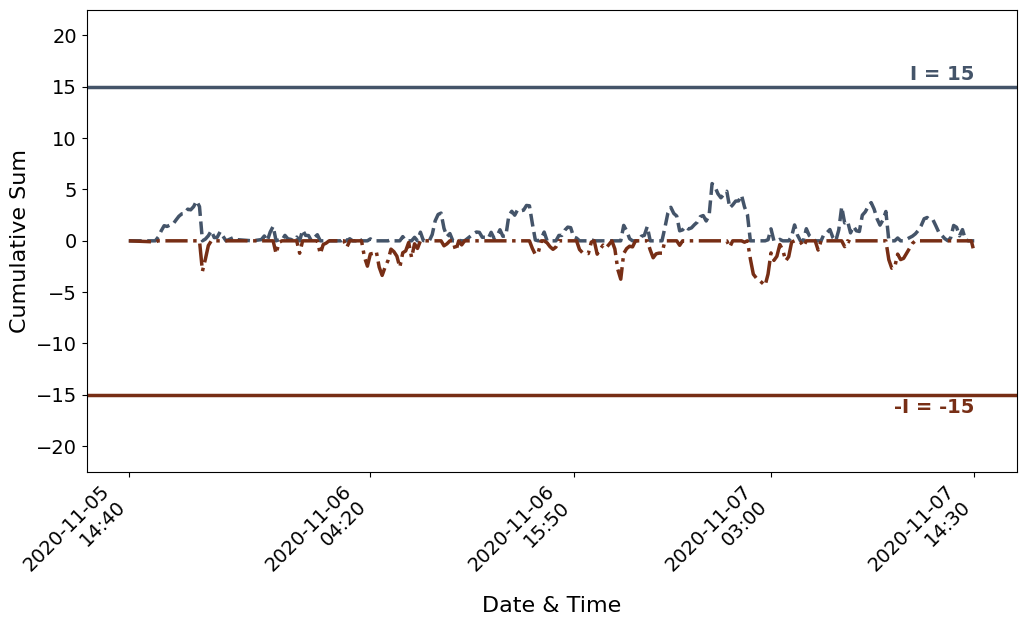

In [439]:
S_neg_healthy_charts = []
S_pos_healthy_charts = []

for i, (st, df) in enumerate(sample_dict_pairs(filtered_result, len(pre_faults), seed=1).items()):
    S_neg, S_pos = get_cusum(df, mlp_large_finetuned, df_scaling)
    S_neg_healthy_charts.append(S_neg)
    S_pos_healthy_charts.append(S_pos)
    
    if i == 5: plot_cusum(S_pos, S_neg, 15, pd.Series(df.index), save_path='plots_final/A1/cusum_healthy.pdf')

22 22

----- 3.0 -----
Precision: 0.5
Recall: 1.0
Notices: [305, 358, 276, 387, 427, 384, 376, 421, 301, 408, 320, 349, 393, 345, 353, 387, 416, 193, 308, 394, 369, 431]

----- 3.5 -----
Precision: 0.5
Recall: 1.0
Notices: [305, 357, 151, 387, 425, 367, 208, 420, 300, 385, 320, 348, 393, 345, 352, 387, 345, 135, 5, 320, 369, 272]

----- 4.0 -----
Precision: 0.5116279069767442
Recall: 1.0
Notices: [304, 356, 151, 386, 425, 366, 207, 419, 300, 384, 320, 348, 384, 345, 352, 384, 345, 135, 5, 320, 368, 272]

----- 4.5 -----
Precision: 0.5116279069767442
Recall: 1.0
Notices: [303, 353, 118, 371, 241, 366, 170, 383, 300, 361, 314, 346, 382, 345, 316, 384, 342, 135, 5, 318, 368, 271]

----- 5.0 -----
Precision: 0.5116279069767442
Recall: 1.0
Notices: [290, 351, 118, 371, 241, 347, 170, 382, 300, 361, 289, 346, 376, 345, 315, 384, 342, 135, 5, 318, 367, 271]

----- 5.5 -----
Precision: 0.5238095238095238
Recall: 1.0
Notices: [2, 2, 113, 421, 207, 347, 170, 382, 300, 361, 289, 346, 374, 345, 30

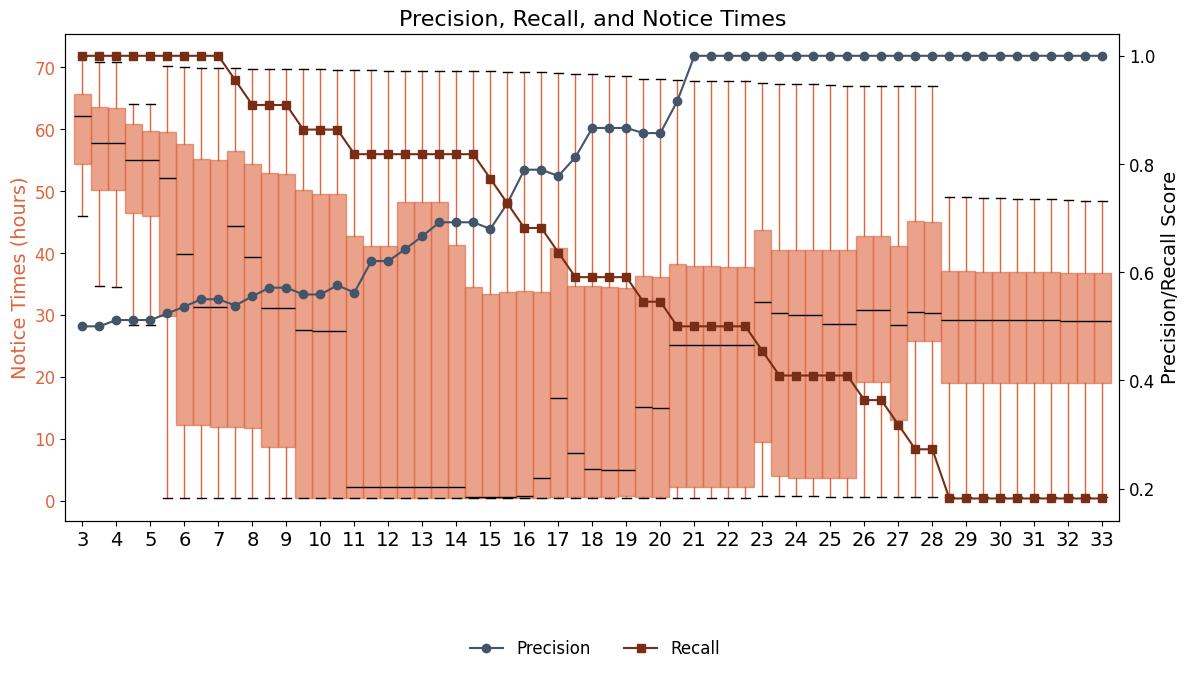

In [393]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming S_neg_healthy_charts, S_neg_faulty_charts, S_pos_healthy_charts, S_pos_faulty_charts,
# and is_out_of_control() are already defined

h_values = np.linspace(3, 33, 30 * 2 + 1)
preds = {}

truth = [0] * len(S_neg_healthy_charts) + [1] * len(S_neg_faulty_charts)
print(len(S_neg_healthy_charts), len(S_neg_faulty_charts))

precision_list = []
recall_list = []
all_notices = []  # To store all notice times for each h value

for h in h_values:
    notices = []
    print(f"\n----- {h} -----")
    preds[h] = []

    for S_neg, S_pos in zip(S_neg_healthy_charts, S_pos_healthy_charts):
        out_of_control, _ = is_out_of_control(S_neg, S_pos, h)
        preds[h].append(out_of_control)

    for S_neg, S_pos in zip(S_neg_faulty_charts, S_pos_faulty_charts):
        out_of_control, notice = is_out_of_control(S_neg, S_pos, h)
        if notice:
            notices.append(notice)
        preds[h].append(out_of_control)

    precision = precision_score(truth, preds[h])
    recall = recall_score(truth, preds[h])

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Notices: {notices}")

    precision_list.append(precision)
    recall_list.append(recall)
    all_notices.append([notice / 6 for notice in notices])  # Convert notice times to hours

# Colors for the plots
colors = ['#445469', '#772E15']

# Create a figure with two y-axes
fig, ax2 = plt.subplots(figsize=(12, 6))

ax1 = ax2.twinx()

# Plot precision and recall
ax1.plot(h_values, precision_list, label="Precision", marker="o", color=colors[0])
ax1.plot(h_values, recall_list, label="Recall", marker="s", color=colors[1])
ax1.set_xlabel("I values", fontsize=14)
ax1.set_ylabel("Precision/Recall Score", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Box plot on the second y-axis
box_plot_data = [notices for notices in all_notices if len(notices) > 0]  # Filter out empty notice lists
valid_h_values = [h for h, notices in zip(h_values, all_notices) if len(notices) > 0]

# Create the box plot
box_positions = valid_h_values
ax2.boxplot(box_plot_data, positions=box_positions, patch_artist=True,
                  boxprops=dict(facecolor="#DC653D", color="#DC653D", alpha=0.6),
                  medianprops=dict(color="black"), whiskerprops=dict(color="#DC653D"),
                  flierprops=dict(marker=None))  # Remove dots for outliers

ax2.set_ylabel("Notice Times (hours)", fontsize=14, color="#DC653D")
ax2.tick_params(axis='y', labelsize=12, labelcolor="#DC653D")

# Customize x-axis ticks to show only integers
int_h_values = [h for h in h_values if h.is_integer()]
ax2.set_xticks(int_h_values)
ax2.set_xticklabels([str(int(h)) for h in int_h_values], fontsize=14)

# Combine legends from both plots and move outside the plot
lines1, labels1 = ax1.get_legend_handles_labels()
fig.legend(lines1, labels1, loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize=12, ncol=2, frameon=False)

plt.title("Precision, Recall, and Notice Times", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to accommodate the legend
plt.show()


22 22

----- 3.0 -----
Precision: 0.5
Recall: 1.0
Mean notice (h): 59.8560606060606
Q1 notice (h): 54.375
Median notice (h): 62.08333333333333
Q3 notice (h): 65.625
[50.83333333 59.66666667 46.         64.5        71.16666667 64.
 62.66666667 70.16666667 50.16666667 68.         53.33333333 58.16666667
 65.5        57.5        58.83333333 64.5        69.33333333 32.16666667
 51.33333333 65.66666667 61.5        71.83333333]

----- 3.5 -----
Precision: 0.5
Recall: 1.0
Mean notice (h): 52.24242424242424
Q1 notice (h): 50.208333333333336
Median notice (h): 57.75
Q3 notice (h): 63.5
[50.83333333 59.5        25.16666667 64.5        70.83333333 61.16666667
 34.66666667 70.         50.         64.16666667 53.33333333 58.
 65.5        57.5        58.66666667 64.5        57.5        22.5
  0.83333333 53.33333333 61.5        45.33333333]

----- 4.0 -----
Precision: 0.5116279069767442
Recall: 1.0
Mean notice (h): 52.09090909090908
Q1 notice (h): 50.166666666666664
Median notice (h): 57.75
Q3 notice

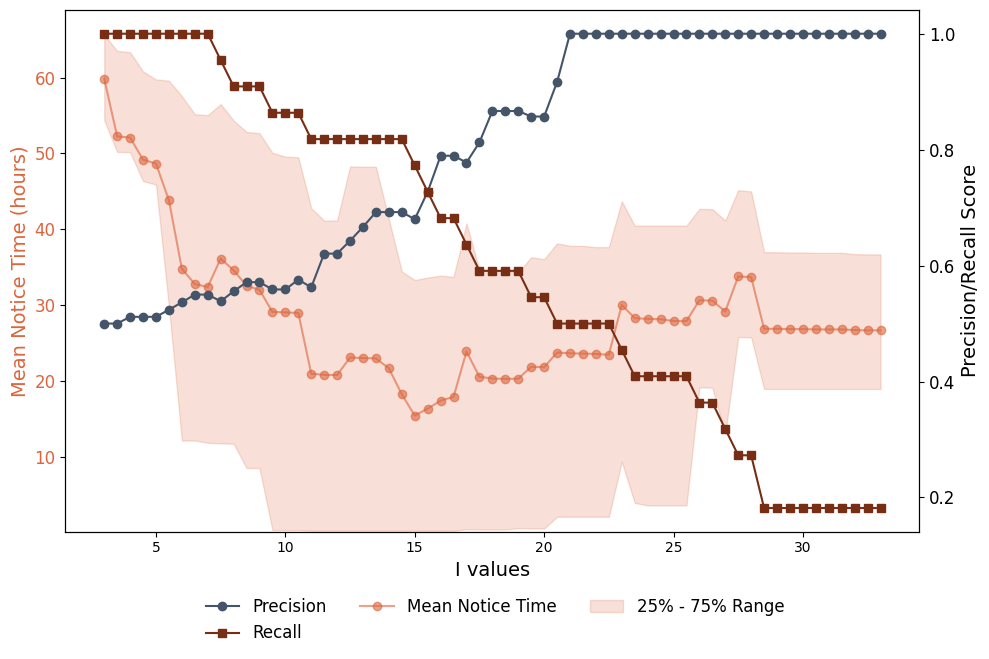

In [450]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Assuming S_neg_healthy_charts, S_neg_faulty_charts, S_pos_healthy_charts, S_pos_faulty_charts,
# and is_out_of_control() are already defined

h_values = np.linspace(3, 33, 30 * 2 + 1)
preds = {}

truth = [0] * len(S_neg_healthy_charts) + [1] * len(S_neg_faulty_charts)
print(len(S_neg_healthy_charts), len(S_neg_faulty_charts))

precision_list = []
recall_list = []
mean_notices = []
q1_notices = []
q3_notices = []

for h in h_values:
    notices = []
    print(f"\n----- {h} -----")
    preds[h] = []

    for S_neg, S_pos in zip(S_neg_healthy_charts, S_pos_healthy_charts):
        out_of_control, _ = is_out_of_control(S_neg, S_pos, h)
        preds[h].append(out_of_control)

    for S_neg, S_pos in zip(S_neg_faulty_charts, S_pos_faulty_charts):
        out_of_control, notice = is_out_of_control(S_neg, S_pos, h)
        if notice:
            notices.append(notice)
        preds[h].append(out_of_control)

    precision = precision_score(truth, preds[h])
    recall = recall_score(truth, preds[h])

    notices = np.array(notices) / 6

    # Calculate the mean and quartiles (Q1, median, Q3)
    if len(notices) > 0:
        mean_notice = np.mean(notices)
        q1 = np.percentile(notices, 25)
        median = np.percentile(notices, 50)
        q3 = np.percentile(notices, 75)
    else:
        mean_notice = q1 = median = q3 = 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Mean notice (h): {mean_notice}")
    print(f"Q1 notice (h): {q1}")
    print(f"Median notice (h): {median}")
    print(f"Q3 notice (h): {q3}")
    print(notices)

    precision_list.append(precision)
    recall_list.append(recall)
    mean_notices.append(mean_notice)
    q1_notices.append(q1)
    q3_notices.append(q3)

# Colors for the plots
colors = ['#445469', '#772E15']

# Plot precision and recall
fig, ax2 = plt.subplots(figsize=(10, 6))

ax1 = ax2.twinx()
# Plot precision and recall in the foreground
ax1.plot(h_values, precision_list, label="Precision", marker="o", color=colors[0], zorder=1)
ax1.plot(h_values, recall_list, label="Recall", marker="s", color=colors[1], zorder=1)
ax1.set_ylabel("Precision/Recall Score", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)

# Create a second y-axis for mean notice time
ax2.plot(h_values, mean_notices, label="Mean Notice Time", marker="o", color="#DC653D", alpha=0.6, zorder=2)
ax2.fill_between(h_values, q1_notices, q3_notices, color="#DC653D", alpha=0.2, zorder=2, label="25% - 75% Range")
ax2.set_ylabel("Mean Notice Time (hours)", fontsize=14, color="#DC653D")
ax2.set_xlabel("I values", fontsize=14)
ax2.set_ylim(0.2, None)  # Set y-axis to start at 0.2
ax2.tick_params(axis='y', labelsize=12, labelcolor="#DC653D")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Move legend lower
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", fontsize=12, ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [394]:
len(S_neg_healthy_charts), len(S_neg_faulty_charts)

(22, 22)

In [395]:
def get_continuous_healthy_sequences(S_neg, S_pos, h, min_length=144*2):
    current_length = 0  # Current sequence length counter
    indices = []
    sizes = []

    for i, (neg, pos) in enumerate(zip(S_neg, S_pos)):
        # Check if both conditions are met for the current pair
        if neg > -h and pos < h:
            current_length += 1  # Increment current sequence length
        else:
            # If conditions break, check if the sequence met the minimum length
            if current_length >= min_length:
                indices.append(i-current_length)
                sizes.append(current_length)
            current_length = 0  # Reset current sequence length

    return pd.DataFrame({'index': indices, 'size': sizes})

H = 5
df_continuous_healthy_sequences = get_continuous_healthy_sequences(S_neg_healthy, S_pos_healthy, H)
date_times = [df_healthy.index[i] for i in df_continuous_healthy_sequences['index']]
df_continuous_healthy_sequences.index = date_times
print(len(df_continuous_healthy_sequences))
df_continuous_healthy_sequences

0


,index,size


In [396]:
df_continuous_healthy_sequences['size'].sum()

0.0

In [397]:
file_path = f'df_continuous_healthy_sequences_h{H}.xlsx'
df_continuous_healthy_sequences.to_excel(file_path, index=True)